In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sizeAsyCutoff = 50.

In [3]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.93, 2.67e-3, 2.21, 3e-3, 3.86, 6.03e-2, -0.51, 5.57e-2, 0.985, 0.93e-3, 0.633 )
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    # parameters from fitting
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.58, -0.007, 1.03, -0.023, 3.99,  \
#            0.041, -1.63, 0.02, 1.11, 0.006, 0.68 )
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []
dstIndSel = [ -120., -100., -75., -50, -25., -5. ,0. ]
for z in dstIndSel:
    for x in range( -7, 8 ):
        for y in range( -12, 10 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            dstArr.append( z )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57. )
            probSapsArr.append( saps_pred_func(x,y,z) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= 0.05\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,-6,-7,0.089514,18,50.0,-120.0
1,-5,-7,0.162988,19,50.0,-120.0
2,-4,-7,0.223678,20,50.0,-120.0
3,-3,-7,0.231361,21,50.0,-120.0
4,-2,-7,0.180367,22,50.0,-120.0


In [4]:
potDF = feather.read_dataframe('../data/potDF.feather')
potDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn,mlt
0,45.0,56.5,-7.0,-2.21,-2.0,2.21,17.0
1,45.0,57.0,-7.0,-3.82,-1.5,3.82,17.0
2,45.0,57.5,-7.0,-5.75,-1.0,5.75,17.0
3,45.0,58.5,-7.0,-7.77,0.0,7.77,17.0
4,45.0,59.0,-7.0,-10.10,0.5,10.10,17.0


In [5]:
# Get number of values for different Asy Inds
# discard those values which have low counts
sizeAsyDF = potDF.groupby("AsyH").size().reset_index()
sizeAsyDF.columns = [ "AsyH", "asyCnt" ]
sizeAsyDF = sizeAsyDF[ sizeAsyDF["asyCnt"] >= sizeAsyCutoff]
potDF = pandas.merge(potDF, sizeAsyDF,\
                     on = "AsyH", how="inner"\
                    ).reset_index(drop=True)
# Get peak potentials
peakPotDF = potDF[[ "AsyH", "potMagn" ]].groupby( "AsyH" ).max().reset_index()
peakPotDF.columns = [ "AsyH", "peakPotMagn" ]

In [6]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func( (asy), a_asy, b_asy):
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

poptPeakPot, pcovPeakPot = curve_fit(peak_pot_fit_func,\
                               (peakPotDF['AsyH'].T),\
                               peakPotDF['peakPotMagn'], p0=(1, 0.1))

print list(poptPeakPot)

print "Vpeak = ", str( round(poptPeakPot[0],2) ), "+", str( round(poptPeakPot[1],2) ), "x log(AsyH-index)"

# get pred peak potentials
peakPotDF["predPeakPot"] = [ peak_pot_fit_func(x, *poptPeakPot) for x in peakPotDF["AsyH"] ]

# Normalize the values of potential
# for every AsyH value. This makes 
# fitting easy!
potDF = pandas.merge( potDF, peakPotDF, on="AsyH" )
potDF["normPot"] = potDF["potMagn"]/potDF["peakPotMagn"]

[-6.4658329852118506, 9.4794209905610565]
Vpeak =  -6.47 + 9.48 x log(AsyH-index)


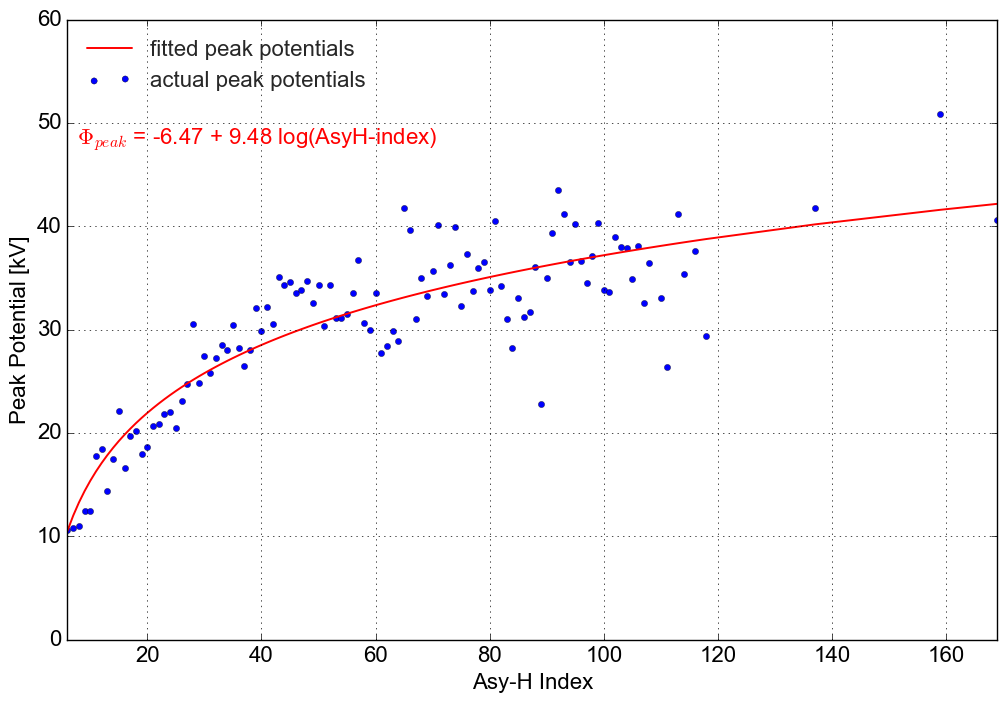

In [7]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.set_style("whitegrid")
sns.set_context("paper")

peakPotDF.plot( x="AsyH", y="peakPotMagn", kind="scatter", ax=ax, label="actual peak potentials" )
peakPotDF.plot( x="AsyH", y="predPeakPot", c="r", ax=ax, label="fitted peak potentials" )

printText = "$\Phi_{peak}$ = " +\
            str( round(poptPeakPot[0],2) ) +\
            " + " + str( round(poptPeakPot[1],2) ) +\
            " log(AsyH-index)"

ax.text(0.01, 0.8,  printText,
            transform=ax.transAxes,
            color='red', fontsize=16)

ax.set_xlabel("Asy-H Index", fontsize=16)
ax.set_ylabel("Peak Potential [kV]", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc=2, scatterpoints=2)

f.savefig( "../figs/potMagFit.pdf" )

In [8]:
# divide data into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
potDF = pandas.concat( [ potDF, \
                    pandas.cut( potDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
potDF.columns = [ "AsyH", "MLAT", "normMLT", "potential",\
                 "normLAT", "potMagn", "mlt", "asyCnt",\
                 "peakPotMagn", "predPeakPot", "normPot", "AsyH-bin" ]

In [9]:
# To estimate the boundary we
# fit second order harmonics!
def mlt_fit_func((mlt, asy), c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b, phiC1_a,\
                 phiC1_b, phiS1_a, phiS1_b):
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    phiC1 = phiC1_a + phiC1_b*asy
    phiS1 = phiS1_a + phiS1_b*asy
    # Now get to the actual function
    phiC = (2*numpy.pi/24.) * mlt + phiC1
    phiS = (2*numpy.pi/24.) * mlt + phiS1
    cosTerm = c1 * numpy.cos(phiC)
    sinTerm = s1 * numpy.sin(phiS)
    cos2Term = c2 * numpy.cos(2*phiC)
    sin2Term = s2 * numpy.sin(2*phiS)
    return cosTerm + sinTerm + cos2Term + sin2Term

In [10]:
potDF["AsyHRnd"] = numpy.round(potDF["AsyH"]/40.)*40.
print potDF["AsyHRnd"].unique()
mltPotDF = potDF[ ["AsyHRnd", "normMLT", "normPot", "mlt"]\
                ].groupby( ["AsyHRnd", "normMLT", "mlt"] \
                ).max().reset_index()
mltPotDF = mltPotDF.dropna()


poptNormPot, pcovNormPot = curve_fit(mlt_fit_func,\
                               (mltPotDF['mlt'].T, mltPotDF['AsyHRnd'].T),\
                               mltPotDF['normPot'], p0=(1., 1., 1., 1., 1., 1.,\
                                                          1., 1., 1., 1., 1., 1.))

print list(poptNormPot)

predAsyArr = []
predMltArr = []
predNormMltArr = []
predPotArr = []
poptPotArr = []

for currAsy in mltPotDF["AsyHRnd"].unique():
    for cpMlt in range(25):
        predMltArr.append( cpMlt )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlt_fit_func(\
                                    (cpMlt, currAsy), *poptNormPot) )
        poptPotArr.append( poptNormPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
predPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLT" : predMltArr,
                "predNormMLT" : predNormMltArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

[  40.   80.  120.  160.    0.]
[-1.3966069282718765, -0.014774170677155873, -0.66835657772308732, -0.015777147479039189, 0.9784260130222836, -0.0059440336414263864, 1.0481839882563362, -0.0083139557426012596, 4.1675182730517788, 0.9486562945932685, 3.4220992002941721, 0.94381290651996874]


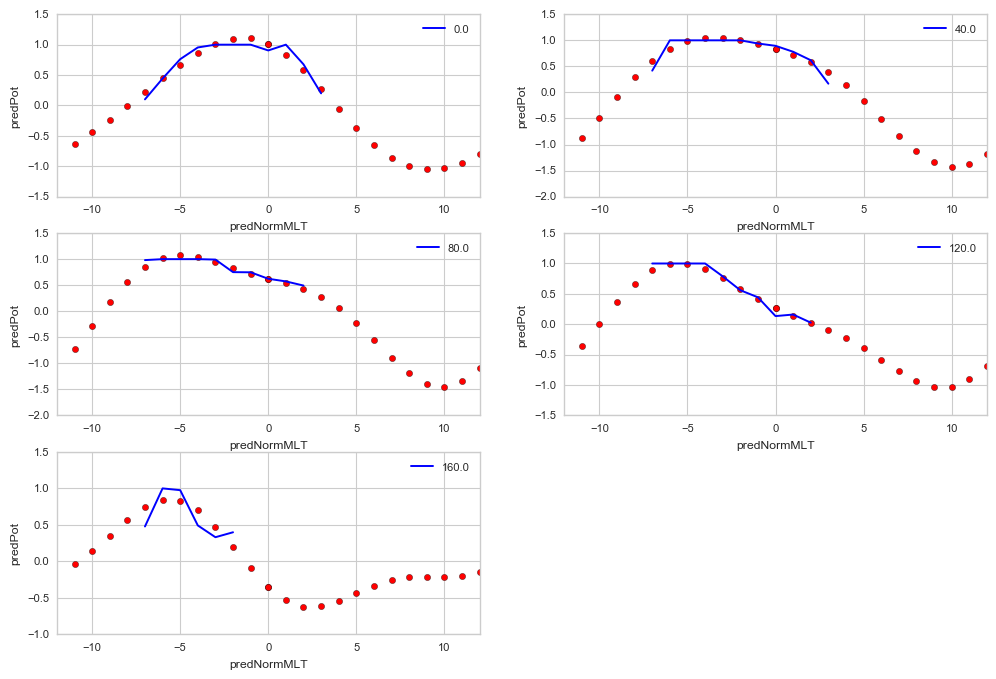

In [11]:
asyList = [ 0., 40., 80., 120., 160. ]
f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(3,2,1) )
ax.append( f.add_subplot(3,2,2) )
ax.append( f.add_subplot(3,2,3) )
ax.append( f.add_subplot(3,2,4) )
ax.append( f.add_subplot(3,2,5) )
seaMap = ListedColormap(sns.color_palette("Reds"))


for pltInd, pltAsy in enumerate( asyList ):
    pltDF = mltPotDF[ (mltPotDF["AsyHRnd"] == pltAsy) ]
    pltDF.plot( x='normMLT',
                y='normPot', ax=ax[pltInd], c='b', label=str(pltAsy))

    pltPredDF = predPotDF[ (predPotDF["predAsy"] == pltAsy) ]
    pltPredDF.plot( x='predNormMLT',
                  y='predPot',ax=ax[pltInd], kind="scatter", c= 'r')
    ax[pltInd].set_xlim( [-12, 12] )

In [25]:
# To estimate the boundary we
# fit second order harmonics!
def mlat_fit_func((mlat, asy),\
            c0_a, c0_b, c1_a,\
            c1_b):
    c0 = c0_a + c0_b * asy
    c1 = c1_a + c1_b * asy
#     c2 = c2_a + c2_b * asy 
    return c0 + c1*mlat #+ c2*numpy.square(mlat)

In [34]:
mlatPotDF = potDF[ ["AsyHRnd", "normLAT", "normPot", "MLAT"]\
                ].groupby( ["AsyHRnd", "normLAT", "MLAT"] \
                ).mean().reset_index()

poptMLATPot, pcovMLATPot = curve_fit(mlat_fit_func,\
                               (mlatPotDF['MLAT'].T, mlatPotDF['AsyHRnd'].T),\
                               mlatPotDF['normPot'], p0=(1., 1., 1., 1.))


# poptMLATPot = [ round(x,2) for x in poptMLATPot ]
print list(poptMLATPot)

predAsyArr = []
predMlatArr = []
predPotArr = []
poptPotArr = []

for currAsy in mlatPotDF["AsyHRnd"].unique():
    for cpMlat in range(50,65,1):
        predMlatArr.append( cpMlat )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlat_fit_func(\
                                    (cpMlat, currAsy), *poptMLATPot) )
        poptPotArr.append( poptMLATPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
predMLATPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

# print predMLATPotDF[ predMLATPotDF["predAsy"] == 40. ][ ["predPot", "predMLAT", "predAsy"] ]

[-4.1384550984951733, -0.0076693623899151782, 0.075381914081199722, 0.00015763115948069724]


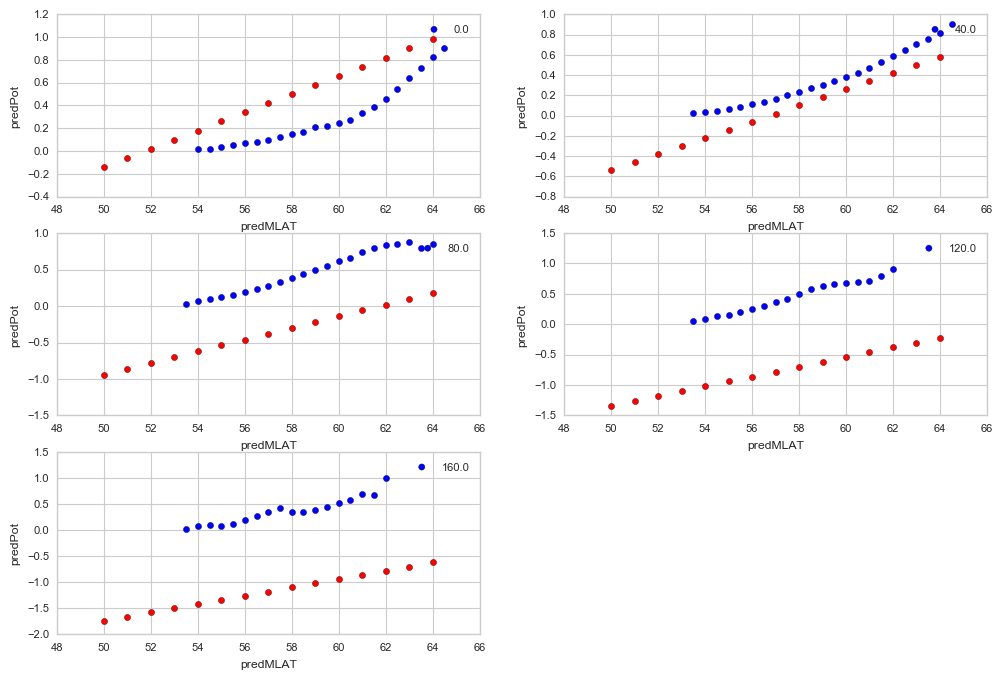

In [33]:
f = plt.figure(figsize=(12, 8))
# axm = f.add_subplot(1,1,1)
ax = []
ax.append( f.add_subplot(3,2,1) )
ax.append( f.add_subplot(3,2,2) )
ax.append( f.add_subplot(3,2,3) )
ax.append( f.add_subplot(3,2,4) )
ax.append( f.add_subplot(3,2,5) )
for cind, casy in enumerate( mlatPotDF["AsyHRnd"].unique() ):
    mlatPotDF[ mlatPotDF["AsyHRnd"] == casy\
             ].plot( x="MLAT", y="normPot", kind="scatter",\
                ax=ax[cind], label=str(casy) )
    subpredMLATPotDF = predMLATPotDF[ (predMLATPotDF["predAsy"] == casy) ]
    subpredMLATPotDF.plot( x='predMLAT',
                  y='predPot', c= 'r',ax=ax[cind], kind="scatter")

In [15]:
predAsyArr = []
predMlatArr = []
predPotArr = []
poptPotArr = []

for currAsy in range(0,151, 10):
    for cpMlat in range(50,65,1):
        predMlatArr.append( cpMlat )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlat_fit_func(\
                                    (cpMlat, currAsy), *poptMLATPot) )
        poptPotArr.append( poptMLATPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
testMLATPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

testMLATPotDF[ testMLATPotDF["predAsy"] == 120. ][ ["predPot", "predMLAT", "predAsy"] ]

,predPot,predMLAT,predAsy
180,-0.17833,50,120
181,-0.12494,51,120
182,-0.06629,52,120
183,-0.00238,53,120
184,0.06679,54,120
185,0.14122,55,120
186,0.22091,56,120
187,0.30586,57,120
188,0.39607,58,120
189,0.49154,59,120


In [16]:
# # To estimate the boundary we
# # fit second order harmonics!
# def mlt_fit_harmonic((mlt), c1, s1, c2, s2, phiC1, phiS1):
#     phiC = (2*numpy.pi/24.) * mlt + phiC1
#     phiS = (2*numpy.pi/24.) * mlt + phiS1
#     cosTerm = c1 * numpy.cos(phiC)
#     sinTerm = s1 * numpy.sin(phiS)
#     cos2Term = c2 * numpy.cos(2*phiC)
#     sin2Term = s2 * numpy.sin(2*phiS)
#     return cosTerm + sinTerm + cos2Term + sin2Term

In [17]:
# asyBinList = [ "(0, 30]", "(30, 60]", "(60, 90]", "(90, 180]" ]
# mltPotDF = potDF[ ["AsyH-bin", "normMLT", "normPot", "mlt"]\
#                 ].groupby( ["AsyH-bin", "normMLT", "mlt"] \
#                 ).max().reset_index()
# mltPotDF = mltPotDF.dropna()

# predAsyBinArr = []
# predMltArr = []
# predNormMltArr = []
# predPotArr = []
# poptPotArr = []

# for currAsyBin in asyBinList:
#     for cpMlt in range(25):
#         predMltArr.append( cpMlt )
#         predAsyBinArr.append( currAsyBin )
#         # Fit params
#         selSubMltDF = mltPotDF[ mltPotDF["AsyH-bin"] == currAsyBin ]
#         poptNormPot, pcovNormPot = curve_fit(mlt_fit_harmonic,\
#                                        (selSubMltDF['mlt'].T),\
#                                        selSubMltDF['normPot'], p0=(1., 1., 1., 1., 1., 1.))
# #         poptNormPot, pcovNormPot = curve_fit(mlt_fit_harmonic,\
# #                                                (selSubMltDF['mlt'].T),\
# #                                                selSubMltDF['normPot'], p0=(1.))
#         predPotArr.append( mlt_fit_harmonic(\
#                                     (cpMlt), *poptNormPot) )
#         poptPotArr.append( poptNormPot )
#         if cpMlt > 12.:
#             normMlt = cpMlt - 24.
#         else:
#             normMlt = cpMlt
#         predNormMltArr.append( normMlt )
    
# predPotDF = pandas.DataFrame({
#                 "predPot" : predPotArr,
#                 "predMLT" : predMltArr,
#                 "predNormMLT" : predNormMltArr,
#                 "predAsyBin" : predAsyBinArr,
#                 "poptPot" : poptPotArr
#                 })

In [18]:
# # get pred values
# predMltArr = []
# predNormMltArr = []
# predPotArr = []

# for cpMlt in range(25):
#     predMltArr.append( cpMlt )
#     predPotArr.append( mlt_fit_harmonic(\
#                                 (cpMlt), *poptNormPot) )
#     if cpMlt > 12.:
#         normMlt = cpMlt - 24.
#     else:
#         normMlt = cpMlt
#     predNormMltArr.append( normMlt )

# predPotDF = pandas.DataFrame({
#                 "predPot" : predPotArr,
#                 "predMLT" : predMltArr,
#                 "predNormMLT" : predNormMltArr
#                 })

In [19]:
# f = plt.figure(figsize=(12, 8))
# ax = []
# ax.append( f.add_subplot(2,2,1) )
# ax.append( f.add_subplot(2,2,2) )
# ax.append( f.add_subplot(2,2,3) )
# ax.append( f.add_subplot(2,2,4) )
# seaMap = ListedColormap(sns.color_palette("Reds"))


# for pltInd, pltAsyBin in enumerate( asyBinList ):
#     pltDF = mltPotDF[ (mltPotDF["AsyH-bin"] == pltAsyBin) ]
#     pltDF.plot( x='normMLT',
#                 y='normPot', ax=ax[pltInd], c='b', label=pltAsyBin)

#     pltPredDF = predPotDF[ (predPotDF["predAsyBin"] == pltAsyBin) ]
#     pltPredDF.plot( x='predNormMLT',
#                   y='predPot',ax=ax[pltInd], kind="scatter", c= 'r')
#     ax[pltInd].set_xlim( [-12, 12] )

In [20]:
# x0 = predPotDF[ predPotDF["predAsyBin"] == "(0, 30]" ]["poptPot"].values[0]
# x30 = predPotDF[ predPotDF["predAsyBin"] == "(30, 60]" ]["poptPot"].values[0]
# x60 = predPotDF[ predPotDF["predAsyBin"] == "(60, 90]" ]["poptPot"].values[0]
# x90 = predPotDF[ predPotDF["predAsyBin"] == "(90, 180]" ]["poptPot"].values[0]

In [21]:
# asyList = [ 0, 30, 60, 90 ]
# f = plt.figure(figsize=(12, 8))
# ax = []
# ax.append( f.add_subplot(3,2,1) )
# ax.append( f.add_subplot(3,2,2) )
# ax.append( f.add_subplot(3,2,3) )
# ax.append( f.add_subplot(3,2,4) )
# ax.append( f.add_subplot(3,2,5) )
# ax.append( f.add_subplot(3,2,6) )

# for pltParamInd, pltParam in enumerate( x0 ):
#     paramList = [ x0[pltParamInd], x30[pltParamInd], x60[pltParamInd], x90[pltParamInd] ]
#     ax[pltParamInd].plot( asyList, paramList, "r*", markersize=10., label=str(pltParamInd) )
#     ax[pltParamInd].legend()
# # f.savefig( "../figs/paramstest.pdf" )